In [8]:
from matplotlib.backends.backend_pdf import PdfPages
from models.lstm import SkipLSTM
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from utils.surface_util import protein_letters_1to3_extended
import seaborn as sns

import pandas as pd
from proemb import alphabets

from models.language_model import ProSEMT

In [5]:
alphabet_name = "uniprot21"
lm_loss = pd.read_csv(f'../../data/saved-models/{alphabet_name}/LM_loss.csv')
upper_range = 280001

### Keep only the projection to remove file dimensions

In [ ]:
# keep only the aa embedding layer saved
steps = list(range(10000, upper_range, 10000))
for i in steps:
    print(i)
    model_path = f"../../data/saved-models/{alphabet_name}/iter_{i}_checkpoint.pt"
    encoder = SkipLSTM(21, 100, 512, 3)
    model = ProSEMT(encoder)
    # only using the encoder weights
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model'], strict=False)

    embeddings = encoder.aa_embedding

    save_path = f"../../data/saved-models/{alphabet_name}/iter_{i}_aa_emb_checkpoint.pt"
    torch.save(embeddings.state_dict(), save_path)

/var/folders/0t/xsc02g1j6z79zd6mkph9lh980000gp/T/ipykernel_90977/1678944692.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(x/1000)}k' for x in ax.get_xticks().tolist()])


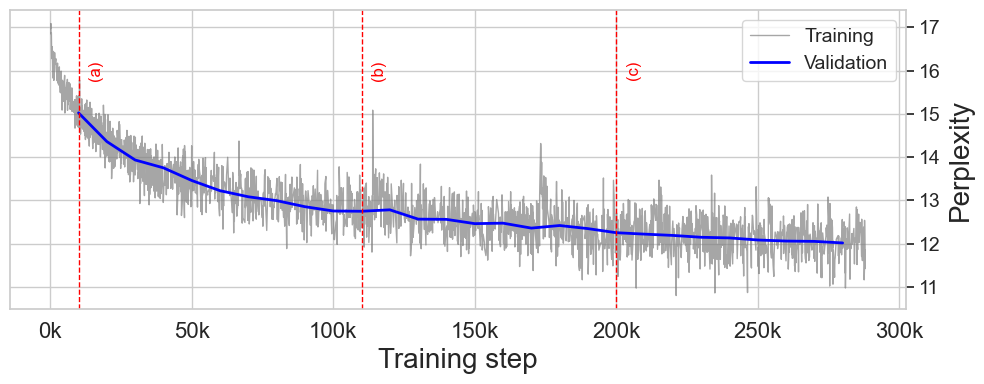

In [6]:
lm_train_loss = pd.read_csv(f'../../data/saved-models/{alphabet_name}/LM_train_loss.csv')
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 4))

ax = sns.lineplot(x="Step", y="Value", data=lm_train_loss
             , color='gray', linewidth=1, alpha=0.7)
sns.lineplot(x="Step", y="Value", data=lm_loss, linewidth=2,  ax=ax,
                  color='blue')

ax.set_ylabel('Perplexity', fontsize=20, labelpad=5)
ax.set_xlabel('Training step', fontsize=20)

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

ax.axvline(10000, color='red', linestyle="--", linewidth=1)
ax.axvline(110000, color='red', linestyle="--", linewidth=1)
ax.axvline(200000, color='red', linestyle="--", linewidth=1)

ax.set_xticklabels([f'{int(x/1000)}k' for x in ax.get_xticks().tolist()])
ax.tick_params(axis='x',labelsize=16)
ax.tick_params(axis='y',labelsize=14)

# add labels to my vertical lines
ax.text(16000, 16, '(a)', fontsize=12, color='red', ha='center', va='center', rotation=90)
ax.text(116000, 16, '(b)', fontsize=12, color='red', ha='center', va='center', rotation=90)
ax.text(206000, 16, '(c)', fontsize=12, color='red', ha='center', va='center', rotation=90)

# add legend
ax.legend(['Training', 'Validation'], fontsize=14)

# save figure
plt.tight_layout()
#plt.savefig(f'results/uniprot21-loss-plot.pdf', bbox_inches='tight', dpi=300)

## For the full alphabet

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000


/var/folders/0t/xsc02g1j6z79zd6mkph9lh980000gp/T/ipykernel_90977/3072370468.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(6, 4))


220000
230000
240000
250000
260000
270000
280000


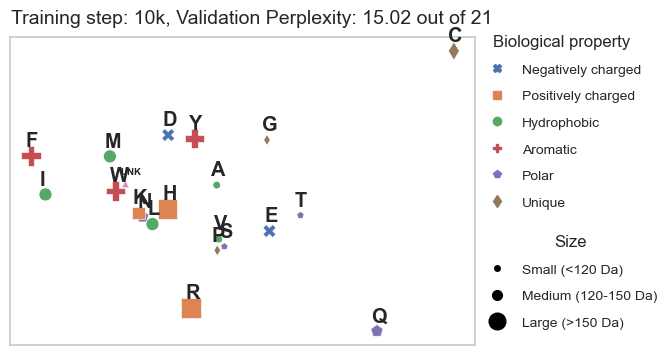

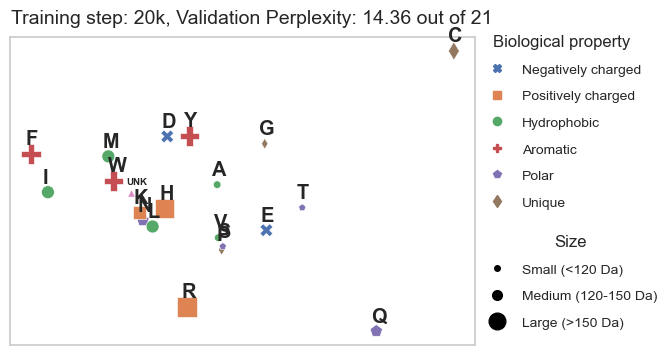

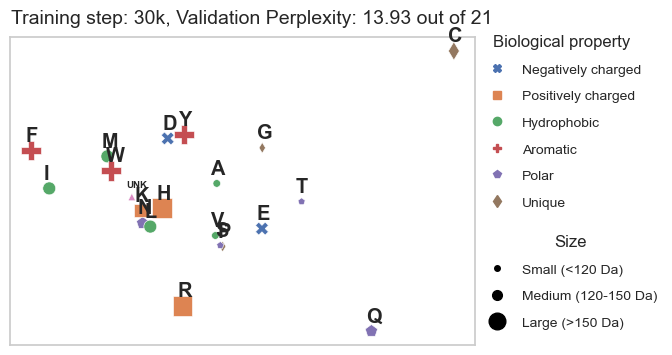

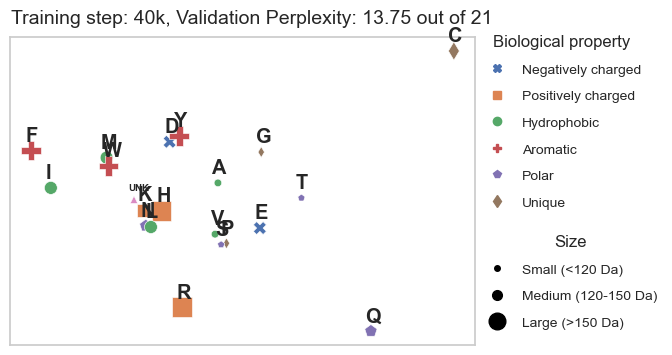

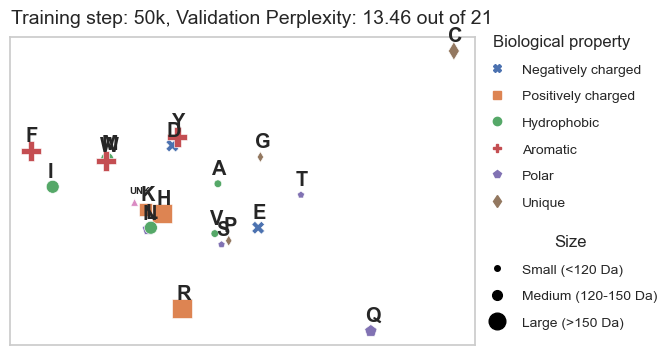

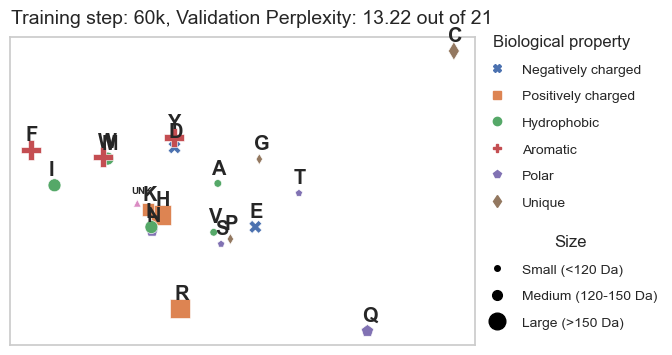

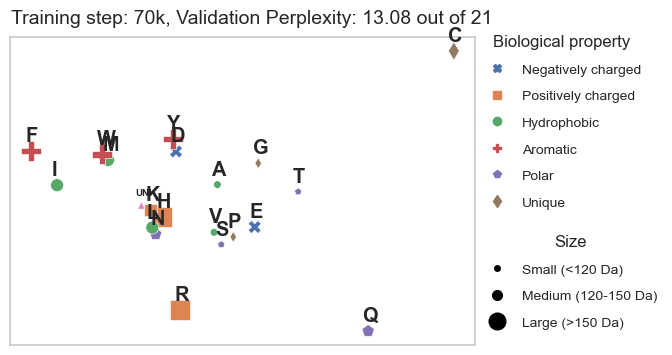

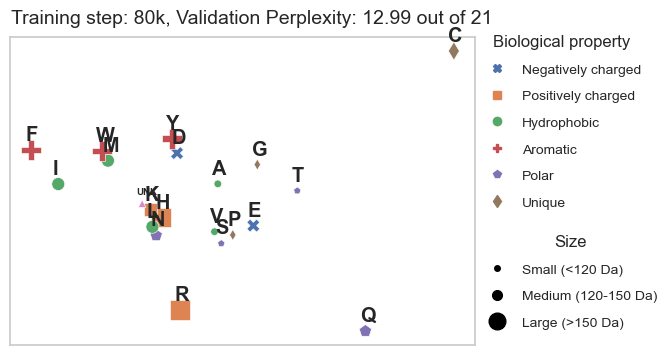

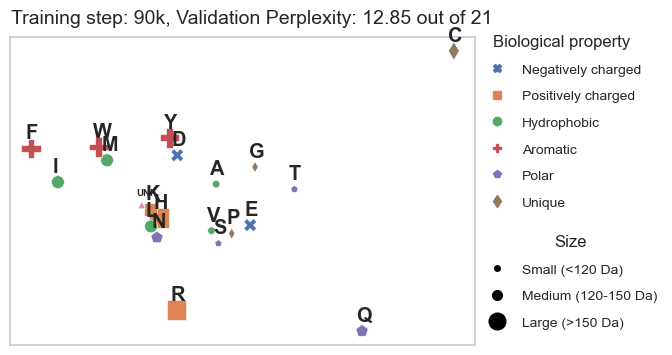

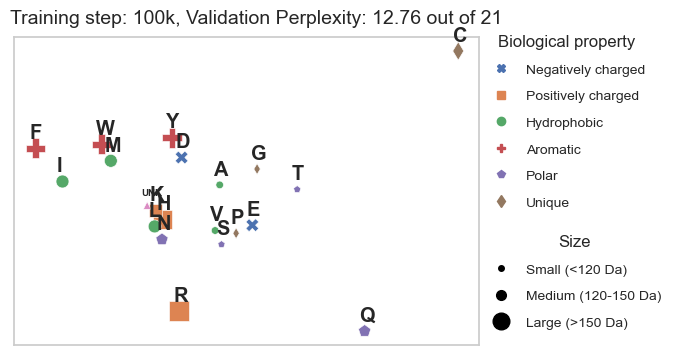

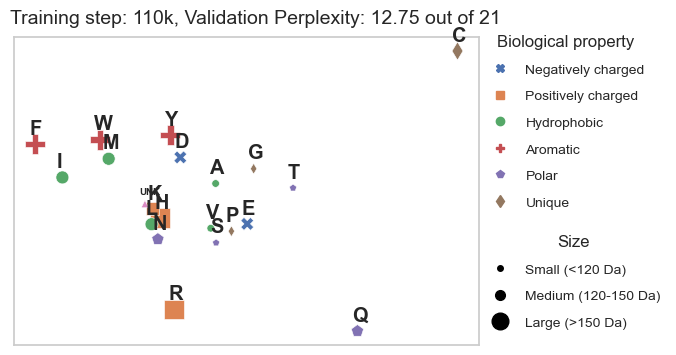

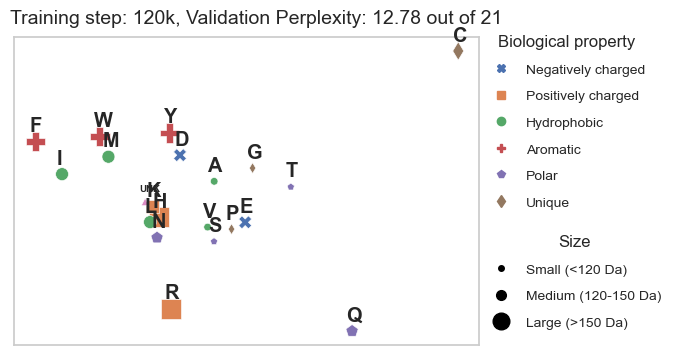

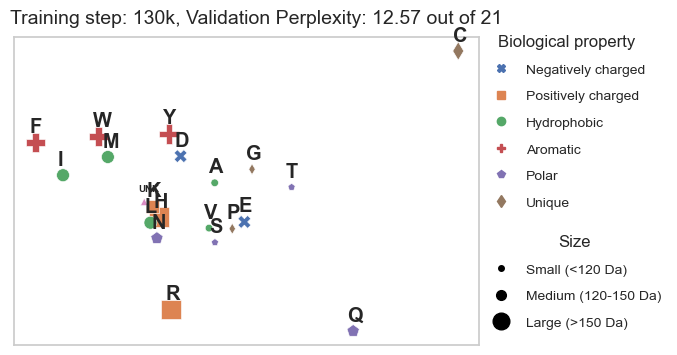

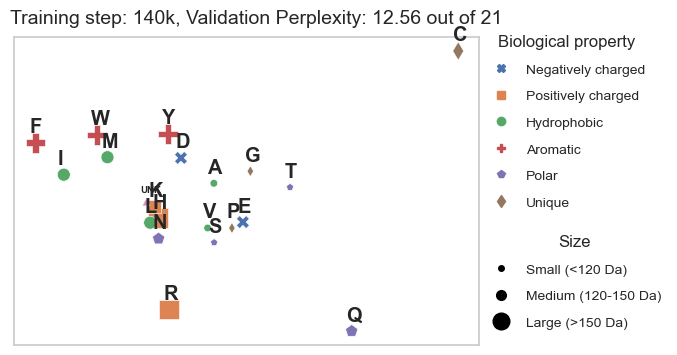

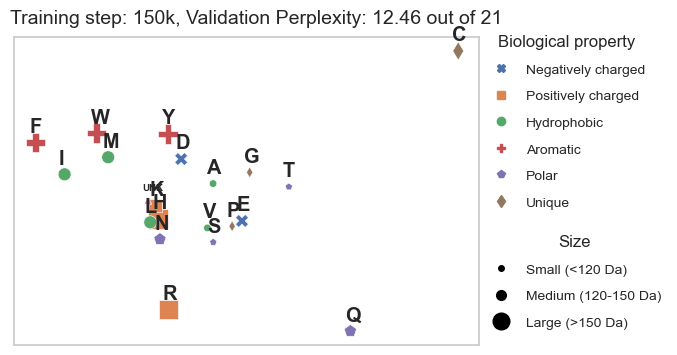

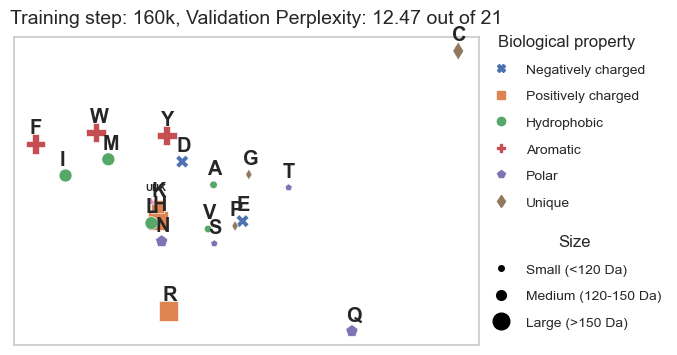

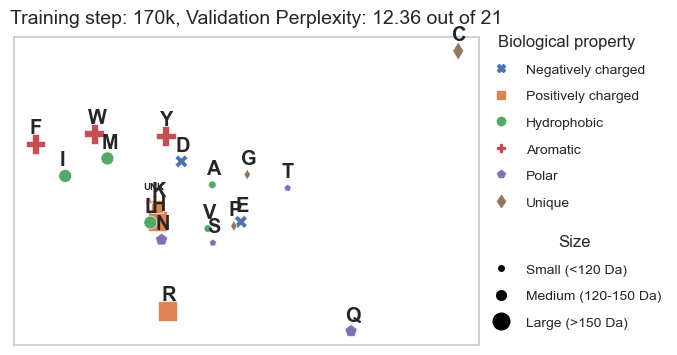

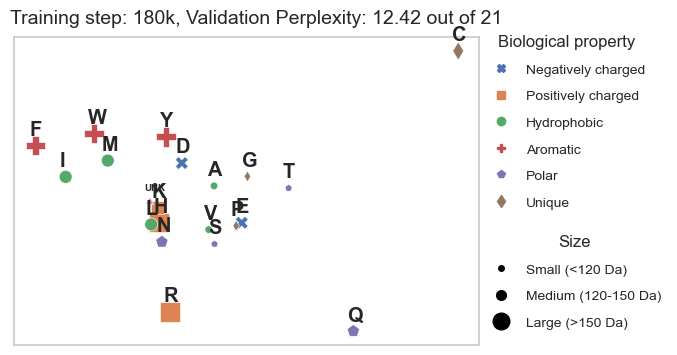

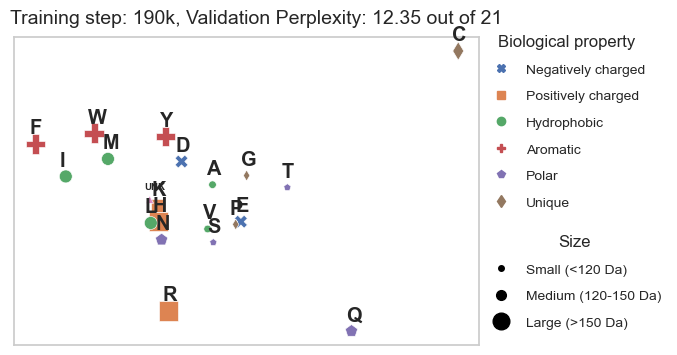

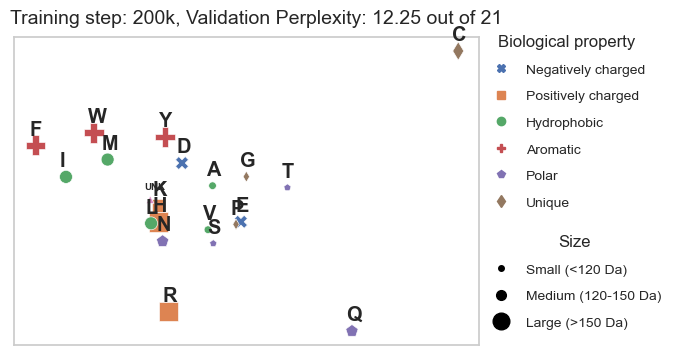

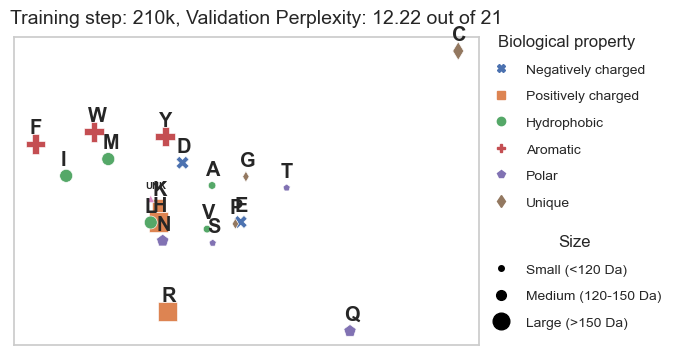

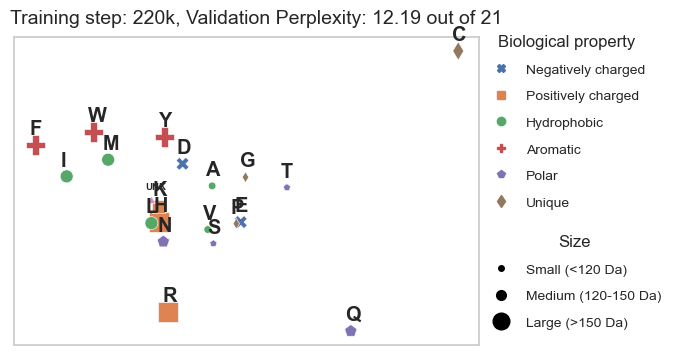

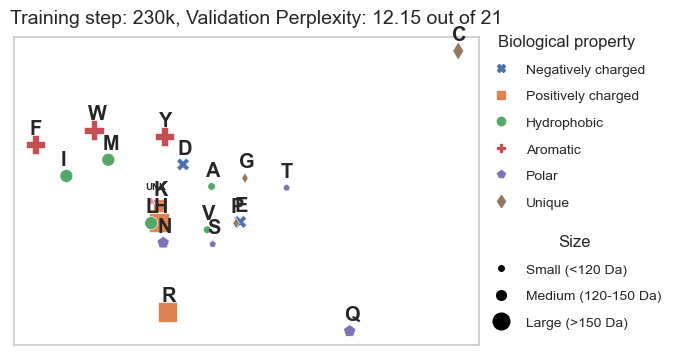

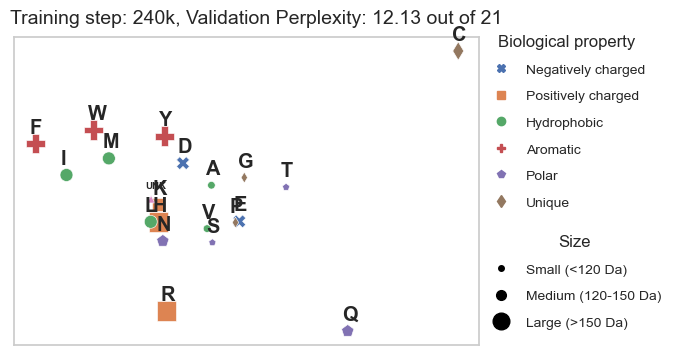

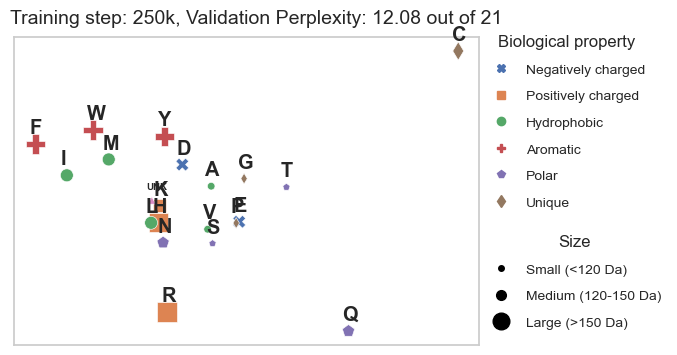

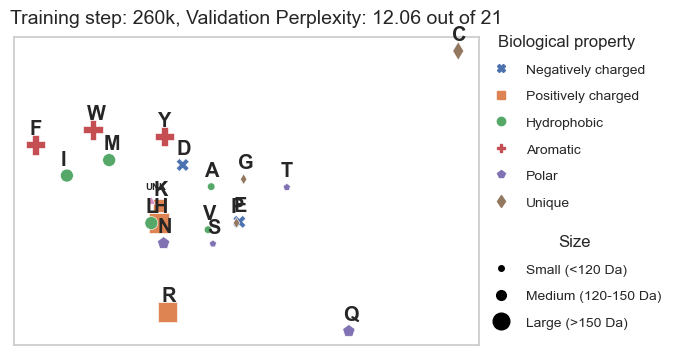

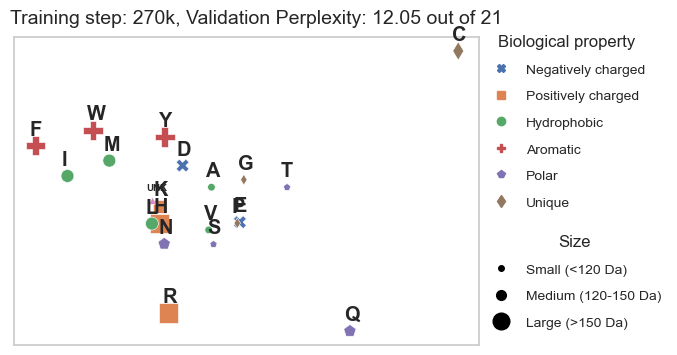

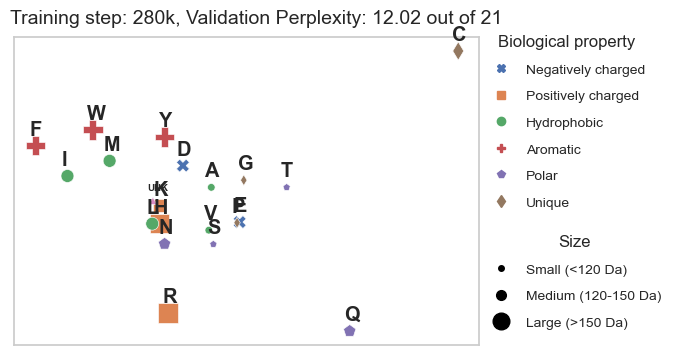

In [9]:
from matplotlib.lines import Line2D
from utils import surface_util
pp = PdfPages(f"{alphabet_name}-embeddings.pdf")
steps = list(range(10000, upper_range, 10000))
for i in steps:
    print(i)
    model_path = f"../../data/saved-models/{alphabet_name}/iter_{i}_aa_emb_checkpoint.pt"
    encoder = SkipLSTM(21, 100, 512, 3)
    model = ProSEMT(encoder)
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    model.skipLSTM.aa_embedding.load_state_dict(checkpoint, strict=True)
    embeddings = encoder.aa_embedding.weight.data.numpy()

    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Plot the reduced embeddings
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))

    alphabet = alphabets.get_alphabet(alphabet_name)

    groups_aa_names = ["" for i in range(21)]
    for (k,v) in alphabet.groupings.items():
        groups_aa_names[v] += k

    group_3let_names = []
    for group in groups_aa_names:
        group_name = ""
        for aa in group:
            group_name += protein_letters_1to3_extended[aa] + " "
        group_3let_names.append(group_name)

    entries_to_keep = [False if a == "" else True for a in groups_aa_names]

    # we only plot the dimensions used during training
    group_3let_names = np.array(group_3let_names)[entries_to_keep]
    group_3let_names[4] = 'CYS'
    groups_aa_names[4] = 'C'
    group_3let_names[-1] = 'UNK'
    groups_aa_names[-1] = 'UNK'
    group_3let_names[11] = 'LYS'
    groups_aa_names[11] = 'K'
    reduced_embeddings = reduced_embeddings[entries_to_keep]

    d = {'group_names': group_3let_names, 'x': reduced_embeddings[:, 0], 'y': reduced_embeddings[:, 1]}
    df = pd.DataFrame(data=d)

    df['1-LET-NAME'] = [surface_util.protein_letters_3to1_extended[a.strip()] if a != 'UNK' else 'UNK' for a in df['group_names']]

    sizes= {'LARGE': 10,'MEDIUM': 5, 'SMALL': 2.5, 'UNK': 2.5}
    df['size'] = [sizes[surface_util.AA_PROP[a.strip()][0]] for a in df['1-LET-NAME']]
    markers={"NEGATIVELY CHARGED": "X", "POSITIVELY CHARGED": "s", "HYDROPHOBIC": "o", "AROMATIC": "P", "POLAR": "p", "UNIQUE": "d", 
             "UNK": "^"}
    df['marker'] = [markers[surface_util.AA_PROP[a.strip()][1]] for a in df['1-LET-NAME']]
    df['prop'] =  [surface_util.AA_PROP[a.strip()][1] for a in df['1-LET-NAME']]
    
    pal = sns.color_palette("deep")
    color_map = {'NEGATIVELY CHARGED': pal[0],
                 'POSITIVELY CHARGED': pal[1],
                 "HYDROPHOBIC": pal[2],
                 "AROMATIC": pal[3],
                 "POLAR": pal[4],
                 "UNIQUE": pal[5],
                 "UNK": pal[6]
                 }
    sns.scatterplot(data=df, x="x", y="y", size=df['size'], hue=df['prop'], style=df['marker'], markers=dict(zip(markers.values(), markers.values())),palette=color_map, sizes=(30, 200))
    
    step = str(int(i/1000))+"k" if i >= 10000 else str(i)
    ax.set_title(f"Training step: {step}, Validation Perplexity: {round(float(lm_loss[lm_loss['Step'] == i].Value), 2)} out of {len(reduced_embeddings)}", fontsize=14,
                 x=0.52, pad=10)
    
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)


    for i, label in enumerate(groups_aa_names):
        size = 'large'
        if label == 'UNK':
            size = 'xx-small'
        ax.text( reduced_embeddings[i, 0] - 0.1, reduced_embeddings[i, 1] + 0.26, label, size=size, weight='bold')
        
          
    elements = [Line2D([], [], marker='X', label='Negatively charged',linestyle='None', color=pal[0], ),
                       Line2D([], [], marker='s', label='Positively charged',  linestyle='None', color=pal[1]),
                       Line2D([], [], marker='o', label='Hydrophobic',  linestyle='None', color=pal[2]),
                       Line2D([], [], marker='P', label='Aromatic',  linestyle='None', color=pal[3]),
                       Line2D([], [], marker='p', label='Polar',  linestyle='None', color=pal[4]),
                       Line2D([], [], marker='d', label='Unique',  linestyle='None', color=pal[5])]

    legend_elements = plt.legend(handles=elements,bbox_to_anchor=(0.99, 1.05), loc=2, prop={'size': 10},labelspacing=1,
              frameon=False, title="Biological property", title_fontsize=12)
    plt.gca().add_artist(legend_elements)
    
    size_el = [
            Line2D([], [], marker='o', label='Small (<120 Da)', linestyle='None', color='black', markersize=4),
            Line2D([], [], marker='o', label='Medium (120-150 Da)', linestyle='None', color='black', markersize=7),
            Line2D([], [], marker='o', label='Large (>150 Da)', linestyle='None', color='black', markersize=12)]
    
    legend_size = plt.legend(handles=size_el, bbox_to_anchor=(0.99, 0.4), loc=2, frameon=False, title="Size", title_fontsize=12, labelspacing=1, prop={'size': 10})
  
    pp.savefig(bbox_inches='tight')
    #plt.close(fig)

pp.close()